In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import vgg16

In [2]:
import cv2
from glob import glob
from tqdm import tqdm


In [3]:
birdspath='./Parsed_Capuchinbird_Clips/*'
nobirdspath='./Parsed_Not_Capuchinbird_Clips/*'

In [4]:
len(glob(birdspath))

217

In [5]:
len(glob(nobirdspath))
birdspaths=glob(birdspath)
nobirdspaths=glob(nobirdspath)

In [6]:
import torchaudio

In [7]:
glob(birdspath)[0]

'./Parsed_Capuchinbird_Clips/XC388470-3.wav'

In [8]:
torchaudio.set_audio_backend("soundfile")

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/1822137616.py:1: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [9]:
import torchaudio
torchaudio.set_audio_backend("soundfile")

waveform, sample_rate = torchaudio.load(birdspaths[4])

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/1775473697.py:2: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [10]:
import torchaudio
print(torchaudio.get_audio_backend())

None


/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/145563050.py:2: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  print(torchaudio.get_audio_backend())


In [11]:
%pip install soundfile


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
torchaudio.get_audio_backend()

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/1746710290.py:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.get_audio_backend()


In [13]:
waveform,sample_rate=torchaudio.load(glob(birdspath)[10])
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0)  # shape: [num_samples]

# Add batch dimension only
waveform = waveform.unsqueeze(0) 

In [14]:
waveform.shape

torch.Size([1, 1, 132300])

In [15]:
sample_rate

44100

In [16]:
spectrogram_transform = torchaudio.transforms.Spectrogram(
    n_fft=1024,       
    win_length=None,  
    hop_length=512,   
    power=2.0       
)

In [17]:
wave=spectrogram_transform(waveform).shape


In [18]:
import matplotlib.pyplot as plt

In [19]:
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [20]:
def convertembeddings(waveform):
    """Convert audio waveform to embeddings using WavLM"""
    # Load pretrained model
    bundle = torchaudio.pipelines.WAVLM_BASE
    model = bundle.get_model().to(device)
    model.eval()
    
    # Ensure waveform is on the correct device and has correct shape
    waveform = waveform.to(device)
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    
    # Ensure waveform has shape [batch, time]
    if waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    
    # Resample if needed
    if bundle.sample_rate != 16000:  # Assuming original is 16kHz
        resampler = torchaudio.transforms.Resample(
            orig_freq=16000, 
            new_freq=bundle.sample_rate
        ).to(device)
        waveform = resampler(waveform)
    
    # Extract features
    with torch.inference_mode():
        features, _ = model.extract_features(waveform)
    
    # Take last hidden layer and mean pool
    embedding_seq = features[-1]  # [1, frames, 768]
    embedding_mean = embedding_seq.mean(dim=1)  # [1, 768]
    
    return embedding_mean.cpu()  # Return to CPU for sto

In [21]:
birdstuples=[]
for i in birdspaths:
    waveform,_=torchaudio.load(i)
    embeding=convertembeddings(waveform)
    birdstuples.append((embeding,1))

In [25]:
from tqdm import tqdm

In [26]:
nobirdstuples=[]
for j in tqdm(nobirdspaths):
    waveform,_=torchaudio.load(j)
    embeding=convertembeddings(waveform)
    nobirdstuples.append((embeding,0))



100%|██████████| 593/593 [07:29<00:00,  1.32it/s]


In [23]:
len(nobirdstuples)

471

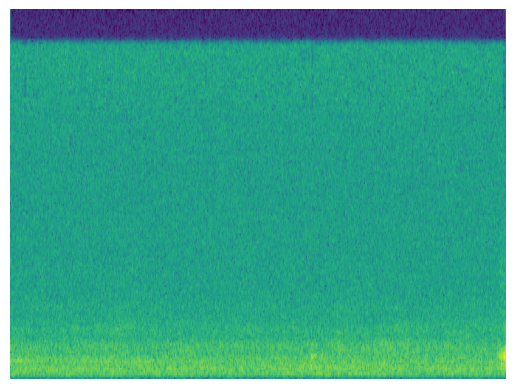

In [27]:
import torchaudio
import matplotlib.pyplot as plt



# 2. Convert to mono (if stereo)
waveform = waveform.mean(dim=0, keepdim=True)

# 3. Compute spectrogram
spec = torchaudio.transforms.Spectrogram()(waveform)

# 4. Convert to dB for better visualization
spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

# 5. Plot and save
plt.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto')
plt.axis('off')  # optional: remove axes for cleaner image
plt.savefig("spectrogram_simple.png", dpi=300)
plt.show()

In [53]:
waveform.shape

torch.Size([1, 134240])

In [54]:
waveform

tensor([[ 0.0042,  0.0040,  0.0147,  ..., -0.0488, -0.0553, -0.0523]])

In [55]:
from torch.utils.data import Dataset,DataLoader
import random
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [56]:
len(birdstuples)

217

In [57]:
class getdataset(Dataset):
    def __init__(self,birdstuples,nobirdstuples):
        self.alltuples=birdstuples+nobirdstuples
        random.shuffle(self.alltuples)
    
    def __len__(self):
        return len(self.alltuples)
    def __getitem__(self,ix):
        tupple=self.alltuples[ix]
        embeding,label=tupple
        embeding=torch.tensor(embeding).to(device)
        label=torch.tensor(label).to(device)

        return embeding,label



In [58]:
def collate_fn(batch):
    """Collate function for DataLoader"""
    embeddings, labels = zip(*batch)
    embeddings = torch.stack(embeddings)  # [batch_size, 768]
    labels = torch.tensor(labels, dtype=torch.float32)
    return embeddings, labels

In [59]:
dataset=getdataset(birdstuples,nobirdstuples)
dataloader=DataLoader(dataset,batch_size=8,shuffle=True,collate_fn=collate_fn)

In [60]:
ds=getdataset(birdstuples,nobirdstuples)
ds[0][0].shape

/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


torch.Size([1, 768])

In [61]:
# waveform=torchaudio.transforms.Resample(orig_freq=sample_rate,new_freq=bundle.sample_rate)

device='mps' if torch.backends.mps.is_available() else 'cpu'

In [62]:
def generateimages(waveform,path):

    waveform = waveform.mean(dim=0, keepdim=True)

# 3. Compute spectrogram
    spec = torchaudio.transforms.Spectrogram()(waveform)

    # 4. Convert to dB for better visualization
    spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

    # 5. Plot and save
    plt.imshow(spec_db.squeeze().numpy(), origin='lower', aspect='auto')
    plt.axis('off')  # optional: remove axes for cleaner image
    plt.savefig("spectrogram_simple.png", dpi=300)
    plt.show()
    

In [63]:
modelc=nn.Sequential(
    nn.Linear(768,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,1),
  
)

In [64]:
from torch.optim import Adam
optimizer=Adam(modelc.parameters(),lr=1e-4)


In [65]:
from torch import nn




In [66]:

loss_fn = torch.nn.BCEWithLogitsLoss()


In [67]:
modelc.to(device)

Sequential(
  (0): Linear(in_features=768, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=1, bias=True)
)

In [68]:
from tqdm import tqdm

In [69]:
epochs = 35
for epoch in range(epochs):
    modelc.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in dataloader:
        embedding, label = batch

        # Move to device
        embedding = embedding.to(device)
        label = label.to(device)

        # Adjust dimensions
        embedding = embedding.squeeze(1)

        # Forward pass
        output = modelc(embedding)

        # Compute loss
        loss = loss_fn(output.float().squeeze(1), label.float())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # --- Accuracy Calculation ---
        with torch.no_grad():
            # For binary classification (sigmoid output)
            preds = torch.round(torch.sigmoid(output.squeeze(1)))
            
            correct += (preds == label).sum().item()
            total += label.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {avg_loss:.4f}  Accuracy: {accuracy:.2f}%")


/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


Epoch [1/35]  Loss: 0.6608  Accuracy: 73.21%
Epoch [2/35]  Loss: 0.5564  Accuracy: 75.43%
Epoch [3/35]  Loss: 0.3843  Accuracy: 85.93%
Epoch [4/35]  Loss: 0.2832  Accuracy: 92.35%
Epoch [5/35]  Loss: 0.2240  Accuracy: 94.20%
Epoch [6/35]  Loss: 0.1714  Accuracy: 95.06%
Epoch [7/35]  Loss: 0.1476  Accuracy: 95.93%
Epoch [8/35]  Loss: 0.1376  Accuracy: 96.54%
Epoch [9/35]  Loss: 0.1305  Accuracy: 96.54%
Epoch [10/35]  Loss: 0.1002  Accuracy: 96.91%
Epoch [11/35]  Loss: 0.1032  Accuracy: 97.28%
Epoch [12/35]  Loss: 0.0986  Accuracy: 97.28%
Epoch [13/35]  Loss: 0.0934  Accuracy: 97.53%
Epoch [14/35]  Loss: 0.0826  Accuracy: 97.65%
Epoch [15/35]  Loss: 0.0780  Accuracy: 97.65%
Epoch [16/35]  Loss: 0.0701  Accuracy: 97.65%
Epoch [17/35]  Loss: 0.0705  Accuracy: 98.02%
Epoch [18/35]  Loss: 0.0722  Accuracy: 97.78%
Epoch [19/35]  Loss: 0.0647  Accuracy: 98.52%
Epoch [20/35]  Loss: 0.0645  Accuracy: 98.02%
Epoch [21/35]  Loss: 0.0575  Accuracy: 98.27%
Epoch [22/35]  Loss: 0.0505  Accuracy: 98.4

In [70]:
import torch

labels = []
for _, label in dataloader:
    labels.append(label)
labels = torch.cat(labels)
print(torch.bincount(labels.int()))


/var/folders/qd/g3_k_1h16fnc16sst1_t_wc40000gn/T/ipykernel_88024/221680463.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeding=torch.tensor(embeding).to(device)


tensor([593, 217])


tensor([[ 0.0042,  0.0040,  0.0147,  ..., -0.0488, -0.0553, -0.0523]])

: 